#### Stage 2 – ADHD Diagnosis and Sex Classification
#### Predictive Modeling – CE888 Final Project

**Diego Armando Salinas Lugo | Student ID: ds24353 / 2401168**

This notebook implements predictive models for classifying:
- **ADHD diagnosis** (binary classification)
- **Sex (Female/Male)** (binary classification)

The models are built using cleaned and preprocessed data from Stage 1, which include:
- Socio-demographic data (categorical)
- Emotional/parenting scales (numerical)
- Functional MRI connectome features (Kernel PCA reduced)

In [73]:
#Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from lime.lime_tabular import LimeTabularExplainer
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import randint, loguniform
import random
import shap
import warnings
warnings.filterwarnings("ignore")

**Loading preproccessed datasets**

In [74]:
# Stage 1 datasets
train_df = pd.read_csv("cleaned_train_data.csv")
val_df = pd.read_csv("cleaned_validation_data.csv")

print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
train_df.head()

Train shape: (970, 117)
Validation shape: (243, 117)


,participant_id,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Externalizing,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Emotional_Problems,APQ_P_APQ_P_ID,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Internalizing,...,kpc_94,kpc_95,kpc_96,kpc_97,kpc_98,kpc_99,kpc_100,ADHD_Outcome,Sex_F,combined_label
0,CPaeQkhcjg7d,0.888748,0.112626,0.876890,1.043100,-1.010412,1.662304,-0.040638,0.822493,1.512199,...,-0.018947,0.015052,0.014926,0.026043,0.013216,-0.000928,0.004189,1,0,1_0
1,Nb4EetVPm3gs,0.541133,0.112626,0.281660,0.336531,-0.524252,-0.144346,-0.823800,0.822493,0.395038,...,0.000298,0.024330,0.038887,0.040289,0.091698,0.009369,0.047024,1,0,1_0
2,p4vPhVu91o4b,1.583979,1.996193,1.769735,1.749669,1.906552,0.758979,-0.301692,0.822493,0.953618,...,-0.014591,-0.010950,0.021610,0.007125,-0.007026,-0.034629,-0.020219,1,1,1_1
3,M09PXs7arQ5E,1.583979,0.818963,0.876890,-0.016754,-0.524252,0.758979,0.481469,0.348166,0.674328,...,0.040847,-0.006969,-0.001195,0.021064,-0.023642,0.004738,-0.052029,1,1,1_1
4,tBGXkEdv2cp7,0.888748,1.054409,0.728083,1.749669,0.934230,-1.047670,-0.301692,1.296820,0.115747,...,-0.010181,-0.014564,-0.024268,-0.051242,0.022815,-0.028150,0.025366,1,0,1_0


*Splitting the original validation set into a new validation set and a final test set (40% for testing)*

In [75]:
# Stratifing based on the combined label (ADHD + Sex) to preserve group proportions
val_df, test_df = train_test_split(
    val_df, test_size=0.4, stratify=val_df["combined_label"], random_state=42
)

print(f"New Validation shape: {val_df.shape}")
print(f"Final Test shape: {test_df.shape}")

New Validation shape: (145, 117)
Final Test shape: (98, 117)


**ADHD Classification – Feature and Target Definition**

- *Target:* `ADHD_Outcome`  
  - 0 = No ADHD  
  - 1 = ADHD  

- *Features:* 
All non-label columns from the merged cleaned dataset 



In [76]:
# Defining target and exclude label/id columns
label_cols = ['ADHD_Outcome', 'Sex_F', 'combined_label']
exclude_cols = ['participant_id'] + label_cols
feature_cols = [col for col in train_df.columns if col not in exclude_cols]

# ADHD target (binary)
X_train = train_df[feature_cols]
y_train = train_df['ADHD_Outcome']

X_val = val_df[feature_cols]
y_val = val_df["ADHD_Outcome"]

X_test = test_df[feature_cols]
y_test = test_df["ADHD_Outcome"]

# Confirming shapes
print("Feature matrix shape:", X_train.shape)
print("Train target shape:", y_train.shape)
print("Validation target shape:", y_val.shape)
print("Test target shape:", y_test.shape)


Feature matrix shape: (970, 113)
Train target shape: (970,)
Validation target shape: (145,)
Test target shape: (98,)


**Class Balance for ADHD Prediction**

Visualizing the distribution of ADHD vs. non-ADHD cases:

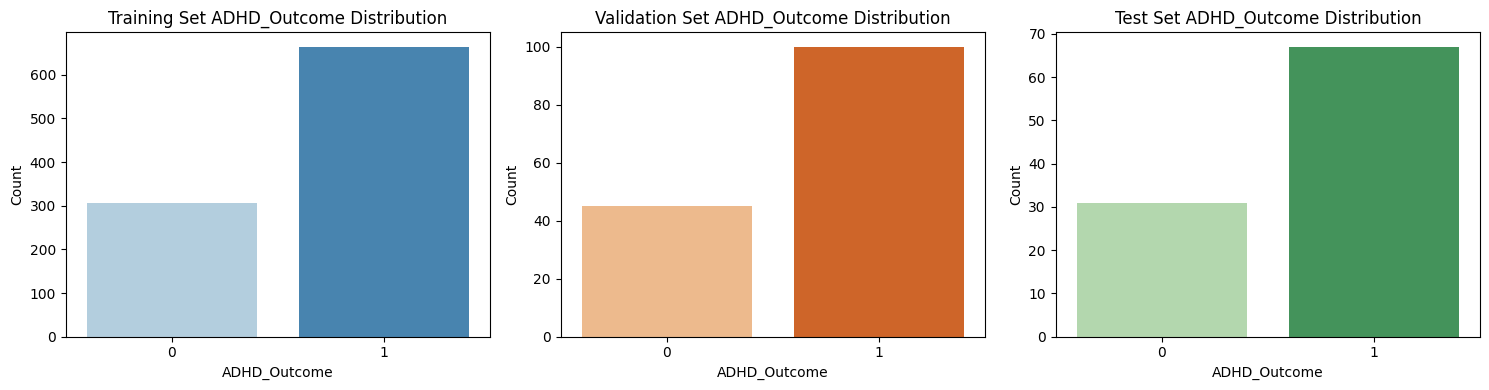

In [77]:
# Function to plot class distribution (Train, Val, Test)
def plot_class_balance(y_train, y_val, y_test, target_name="ADHD_Outcome"):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    sns.countplot(x=y_train, ax=axes[0], palette="Blues")
    axes[0].set_title(f"Training Set {target_name} Distribution")
    axes[0].set_xlabel(target_name)
    axes[0].set_ylabel("Count")

    sns.countplot(x=y_val, ax=axes[1], palette="Oranges")
    axes[1].set_title(f"Validation Set {target_name} Distribution")
    axes[1].set_xlabel(target_name)
    axes[1].set_ylabel("Count")

    sns.countplot(x=y_test, ax=axes[2], palette="Greens")
    axes[2].set_title(f"Test Set {target_name} Distribution")
    axes[2].set_xlabel(target_name)
    axes[2].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

plot_class_balance(y_train, y_val, y_test, "ADHD_Outcome")


Reflect the same distribution due to stratified sampling

This imbalance must be considered during modelling, especially when choosing the evaluation metrics to use since class imbalance can bias models and evaluation:
- **Recall** 
- **AUC-ROC**
- **F1-Score**


**Evaluation Function for multipe times use**


In [78]:
def evaluate_model(y_true, y_pred, y_prob, model_name="Model"):
    print(f"{model_name} – Evaluation Metrics\n")
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("AUC-ROC Score:", round(roc_auc_score(y_true, y_prob), 4))
    
    metrics = {
        "Accuracy": float(accuracy_score(y_true, y_pred)),
        "Precision": float(precision_score(y_true, y_pred)),
        "Recall": float(recall_score(y_true, y_pred)),
        "F1 Score": float(f1_score(y_true, y_pred)),
        "AUC": float(roc_auc_score(y_true, y_prob))
    }
    return metrics

**Baseline Model – Logistic Regression (ADHD Prediction)**

A baseline **Logistic Regression** model with `class_weight='balanced'` to address the ADHD class imbalance.

In [79]:
# Baseline logistic regression
logreg = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')  # Balanced to counter ADHD class imbalance
logreg.fit(X_train, y_train)

# Predicting and get probabilities
y_pred_log = logreg.predict(X_val)
y_prob_log = logreg.predict_proba(X_val)[:, 1]

# Evaluating
log_metrics = evaluate_model(y_val, y_pred_log, y_prob_log, "Logistic Regression (ADHD)")

Logistic Regression (ADHD) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.62      0.61        45
           1       0.83      0.81      0.82       100

    accuracy                           0.75       145
   macro avg       0.71      0.72      0.71       145
weighted avg       0.75      0.75      0.75       145

Confusion Matrix:
 [[28 17]
 [19 81]]
AUC-ROC Score: 0.8271


The **Logistic Regression** model with `class_weight='balanced'` achieved:

- **Accuracy:** 75% — balanced overall performance across both classes.
- **AUC-ROC:** 0.827 — indicates good ability to distinguish ADHD from non-ADHD.
- **Recall (ADHD class = 1):** 0.81 — this is particularly important in clinical contexts, where missing a true ADHD case can have consequences.
- **Recall (No ADHD class = 0):** 0.62 — some false positives are present, but the model still performs acceptably on the negative class.

The **precision-recall balance is strong**, making this a competitive and interpretable baseline model.  



**Random Forest Classifier – ADHD Prediction**

Random Forests are ensemble models that build multiple decision trees and aggregate their predictions.  
They tend to handle **non-linearities** and **feature interactions** well and are generally robust to overfitting.

In [80]:
# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_val)
y_prob_rf = rf_model.predict_proba(X_val)[:, 1]

# Evaluation
rf_metrics = evaluate_model(y_val, y_pred_rf, y_prob_rf, "Random Forest (ADHD)")

Random Forest (ADHD) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.44      0.59        45
           1       0.80      0.97      0.87       100

    accuracy                           0.81       145
   macro avg       0.83      0.71      0.73       145
weighted avg       0.82      0.81      0.79       145

Confusion Matrix:
 [[20 25]
 [ 3 97]]
AUC-ROC Score: 0.8269


The **Random Forest** model performs **very well** overall, with:

- **Accuracy:** 81% — slightly higher than the logistic regression baseline.
- **AUC-ROC:** 0.827 — strong ability to distinguish between ADHD and non-ADHD cases.
- **Recall (ADHD class = 1):** 0.97 — extremely high sensitivity, meaning almost all ADHD cases are detected.
- **Recall (No ADHD class = 0):** 0.44 — lower than logistic regression, indicating more false positives for the non-ADHD class.

This model is highly **sensitive to ADHD cases**, making it ideal for medical screening, where **missing a diagnosis is riskier** than over-diagnosing.


**XGBoost Classifier – ADHD Prediction**

*XGBoost* is an advanced gradient boosting algorithm known for its high accuracy, speed, and handling of class imbalance through `scale_pos_weight` or `class_weight`.

It builds trees sequentially and corrects errors made by previous trees.  

This model is often very effective for structured/tabular medical data.

In [81]:
# XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_val)
y_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Evaluation
xgb_metrics = evaluate_model(y_val, y_pred_xgb, y_prob_xgb, "XGBoost (ADHD)")


XGBoost (ADHD) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.22      0.36        45
           1       0.74      1.00      0.85       100

    accuracy                           0.76       145
   macro avg       0.87      0.61      0.61       145
weighted avg       0.82      0.76      0.70       145

Confusion Matrix:
 [[ 10  35]
 [  0 100]]
AUC-ROC Score: 0.8281


- **Accuracy:** 76% — competitive with both Logistic Regression and Random Forest.
- **AUC-ROC:** 0.828 — reflects strong separation between classes.
- **Recall (ADHD class = 1):** 1.00 — perfect recall means all ADHD cases were correctly identified.
- **Recall (No ADHD class = 0):** 0.22 — extremely low, indicating that most non-ADHD cases were misclassified as ADHD.

This model shows **strong predictive power** for ADHD, which is important clinically, but at a cost of **very high false positives** 
 
To address this, the following can be executed:
- Tuning with `scale_pos_weight` to balance predictions




**Multi-Layer Perceptron (MLP) – ADHD Prediction**

An **MLP** is a type of feedforward neural network that can capture complex, non-linear interactions between features.  
This is especially useful for datasets with mixed data types.


In [82]:
# Multi-Layer Perceptron Classifier
# Simple architecture with one hidden layer of 100 neurons
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_model.fit(X_train, y_train)

# Predictions
y_pred_mlp = mlp_model.predict(X_val)
y_prob_mlp = mlp_model.predict_proba(X_val)[:, 1]

# Evaluation
mlp_metrics = evaluate_model(y_val, y_pred_mlp, y_prob_mlp, "MLP (ADHD)")

MLP (ADHD) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50        45
           1       0.77      1.00      0.87       100

    accuracy                           0.79       145
   macro avg       0.88      0.67      0.68       145
weighted avg       0.84      0.79      0.75       145

Confusion Matrix:
 [[ 15  30]
 [  0 100]]
AUC-ROC Score: 0.8364


- **Accuracy:** 79% — strong overall performance, slightly behind Random Forest.
- **AUC-ROC:** 0.836 — highest among the tested models.
- **Recall (ADHD class = 1):** 1.00 — perfect detection of all ADHD cases.
- **Recall (No ADHD class = 0):** 0.33 — one-third of non-ADHD participants were correctly classified.


This shows similar results to the behavior seen in XGBoost:
- Very **strong performance on ADHD detection**
- **Weak performance on non-ADHD cases**, likely due to class imbalance and the MLP’s sensitivity to data imbalance

**Support Vector Machine (SVM) – ADHD Prediction**

Support Vector Machines are effective for **binary classification**, particularly in high-dimensional spaces.


In [83]:
# Support Vector Machine
# A RBF kernel is used with `probability=True` to allow ROC-AUC scoring.  
svm_model = SVC(kernel='rbf', probability=True, random_state=42, class_weight='balanced')
svm_model.fit(X_train, y_train)

# Evaluating
y_pred_svm = svm_model.predict(X_val)
y_prob_svm = svm_model.predict_proba(X_val)[:, 1]
svm_metrics = evaluate_model(y_val, y_pred_svm, y_prob_svm, "SVM (Balanced)")

SVM (Balanced) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        45
           1       0.69      1.00      0.82       100

    accuracy                           0.69       145
   macro avg       0.34      0.50      0.41       145
weighted avg       0.48      0.69      0.56       145

Confusion Matrix:
 [[  0  45]
 [  0 100]]
AUC-ROC Score: 0.1969


- **Accuracy:** 69% — misleading due to predicting all samples as ADHD.
- **AUC-ROC:** 0.197 — very poor class separation, indicating overfitting.
- **Recall (ADHD class = 1):** 1.00 — predicts all participants as ADHD, so captures 100% of ADHD cases.
- **Recall (No ADHD class = 0):** 0.00 — fails to identify any non-ADHD cases.

This confirms that **SVM is overfitting to the majority class** even with balancing.


**K-Nearest Neighbors (KNN) – ADHD Prediction**

*KNN* is a distance-based, non-parametric algorithm that classifies a sample based on the majority class among its **k** closest neighbors.

It is simple and interpretable but can struggle with **high-dimensional** or **imbalanced** data, as all features contribute equally to distance.



In [84]:
knn_model = KNeighborsClassifier(n_neighbors=5) # default k=5 to observe baseline performance and compare it with other classifiers.
knn_model.fit(X_train, y_train)

# Predictions
y_pred_knn = knn_model.predict(X_val)
y_prob_knn = knn_model.predict_proba(X_val)[:, 1]

# Evaluation
knn_metrics = evaluate_model(y_val, y_pred_knn, y_prob_knn, "KNN (ADHD)")


KNN (ADHD) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.42      0.52        45
           1       0.78      0.91      0.84       100

    accuracy                           0.76       145
   macro avg       0.73      0.67      0.68       145
weighted avg       0.75      0.76      0.74       145

Confusion Matrix:
 [[19 26]
 [ 9 91]]
AUC-ROC Score: 0.7574


- **Accuracy:** 76% — comparable to Logistic Regression and MLP.
- **AUC-ROC:** 0.757 — lower than other models tested, suggesting weaker class separation.
- **Recall (ADHD class = 1):** 0.91 — strong recall, meaning the model effectively detects ADHD cases.
- **Recall (No ADHD class = 0):** 0.42 — modest performance, indicating some difficulty detecting non-ADHD.

Despite being a simple algorithm, KNN shows *not too bad perfomance*, especially for detecting ADHD (class 1). However, it doesn´t represent good performance as others. 

**ROC Curve Comparison – ADHD Prediction**

To visually compare model performance, **ROC curves** for all models are plotted.

The ROC curve shows the **True Positive Rate (Recall)** vs. the **False Positive Rate** across thresholds.  
A model that hugs the top-left corner indicates stronger separability between classes.


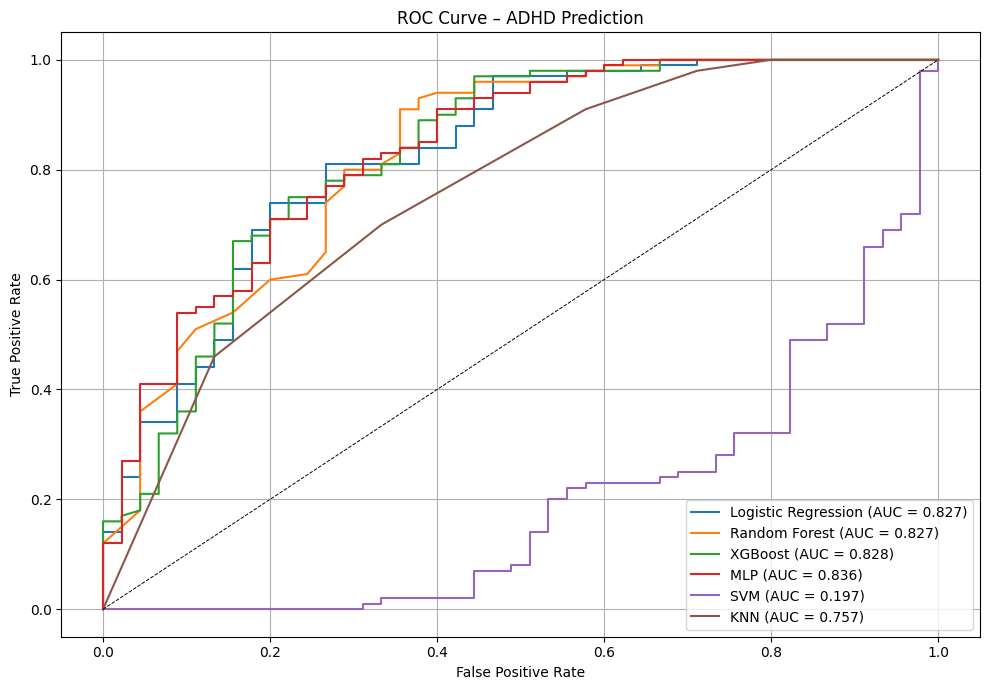

In [85]:
# Generating ROC curve points
models_roc = {
    "Logistic Regression": (y_val, y_prob_log),
    "Random Forest": (y_val, y_prob_rf),
    "XGBoost": (y_val, y_prob_xgb),
    "MLP": (y_val, y_prob_mlp),
    "SVM": (y_val, y_prob_svm),
    "KNN": (y_val, y_prob_knn)
}

# Plotting
plt.figure(figsize=(10, 7))

for name, (true, prob) in models_roc.items():
    fpr, tpr, _ = roc_curve(true, prob)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

plt.plot([0, 1], [0, 1], 'k--', linewidth=0.7)
plt.title("ROC Curve – ADHD Prediction")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


*Key Insights:*

- *MLP and XGBoost* lead in AUC, but with poor non-ADHD recall
- *Random Forest* strikes the best balance: high accuracy, ADHD recall + decent AUC + interpretability
- *SVM* is unsuitable, applying class balancing, it shows **no discriminative power**

**Random Forest** model – The selected ADHD predictor.

**Hyperparameter Tuning and Cross-Validation – Random Forest (ADHD)**


RandomizedSearchCV for Random Forest (ADHD Prediction) 

This method enables efficient exploration of a broad hyperparameter space by randomly sampling combinations rather than performing an exhaustive grid search.

The tuning process is guided by the **F1-score**, which balances precision and recall, a relevant metric for ADHD prediction, where high recall is prioritized to minimize false negatives, while maintaining acceptable precision.

In [ ]:
# Random search version of the hyperparameter space
rf_random_grid = {
    'n_estimators': randint(100, 500), # number of trees in the forest
    'max_depth': [None, 10, 20, 30, 50], # maximum tree depth, including unrestricted (`None`)
    'min_samples_split': [2, 5, 10], # control tree complexity and reduce overfitting
    'min_samples_leaf': [1, 2, 4], # leafs
    'max_features': ['sqrt', 'log2', None], # features considered at each split
    'bootstrap': [True, False], # whether bootstrap sampling is used
    'class_weight': ['balanced'] # to address class imbalance
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_random_grid,
    n_iter=50,  
    scoring='f1',
    cv=skf,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

rf_random.fit(X_train, y_train)
best_rf_model = rf_random.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [87]:
print("Best parameters found:", rf_random.best_params_)

Best parameters found: {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 403}


Evaluating the best random forest on the validation set

In [88]:
y_pred_best_rf = best_rf_model.predict(X_val)
y_prob_best_rf = best_rf_model.predict_proba(X_val)[:, 1]
evaluate_model(y_val, y_pred_best_rf, y_prob_best_rf, "Randomized Tuned RF (ADHD)")

Randomized Tuned RF (ADHD) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.47      0.60        45
           1       0.80      0.96      0.87       100

    accuracy                           0.81       145
   macro avg       0.82      0.71      0.74       145
weighted avg       0.81      0.81      0.79       145

Confusion Matrix:
 [[21 24]
 [ 4 96]]
AUC-ROC Score: 0.836


{'Accuracy': 0.8068965517241379,
 'Precision': 0.8,
 'Recall': 0.96,
 'F1 Score': 0.8727272727272727,
 'AUC': 0.8360000000000001}

Evaluating the best random forest model on test set

In [89]:
# Final evaluation on the test set (ADHD)
print("Final Evaluation – Random Forest on Test Set (ADHD)")
y_pred_rf_final = best_rf_model.predict(X_test)
y_prob_rf_final = best_rf_model.predict_proba(X_test)[:, 1]

evaluate_model(y_test, y_pred_rf_final, y_prob_rf_final, "Final Random Forest (ADHD)")


Final Evaluation – Random Forest on Test Set (ADHD)
Final Random Forest (ADHD) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.68      0.70        31
           1       0.86      0.88      0.87        67

    accuracy                           0.82        98
   macro avg       0.79      0.78      0.78        98
weighted avg       0.81      0.82      0.81        98

Confusion Matrix:
 [[21 10]
 [ 8 59]]
AUC-ROC Score: 0.8657


{'Accuracy': 0.8163265306122449,
 'Precision': 0.855072463768116,
 'Recall': 0.8805970149253731,
 'F1 Score': 0.8676470588235294,
 'AUC': 0.8656716417910448}

**Final Evaluation – Random Forest on Test Set (ADHD)**

The final tuned **Random Forest Classifier**, evaluated on the hold-out test set, demonstrates strong generalization performance and confirms its robustness as the chosen model.

**Test Set Metrics:**

- **Accuracy:** 82%
- **AUC-ROC:** 0.866 — excellent class separation
- **Recall (ADHD class = 1):** 0.88 — still high, maintaining clinical reliability
- **Recall (No ADHD class = 0):** 0.68 — representing good perfomance
- **F1 Score:** 0.87 for ADHD class.


- The model maintains **high recall for ADHD cases**, ensuring few missed diagnoses — a core requirement in clinical applications.
- It also **generalizes well**, showing good recall for non-ADHD cases.
- **Balanced precision-recall tradeoff** across both classes supports its use in practical settings.


**LIME Explainability – Random Forest (ADHD)**

*LIME* (Local Interpretable Model-agnostic Explanations).

LIME builds a local surrogate model around a single prediction to show which features increased or decreased the ADHD probability.

This applied to a random instance from the test set to explain the Random Forest (the final model) prediction : 



In [90]:
# Converting to arrays
X_train_array = X_train.values
X_test_array = X_test.values

# LIME Explainer
lime_explainer = LimeTabularExplainer(
    training_data=X_train_array,  # Training set data for training LIME
    feature_names=X_train.columns,
    class_names=["No ADHD", "ADHD"],
    mode="classification"
)

# Random instance from the test set
idx = random.randint(0, X_test_array.shape[0] - 1)
print(f"Explaining instance #{idx} — Participant ID: {X_test.index[idx]}")

# Explaining the selected instance using the final Random Forest model
lime_exp = lime_explainer.explain_instance(
    data_row=X_test_array[idx],
    predict_fn=best_rf_model.predict_proba  # Using the final model
)

# Showing the explanation
lime_exp.show_in_notebook()

Explaining instance #39 — Participant ID: 148


**LIME Explanation – Random Forest (ADHD)**

*Top Contributing Features:*

- **SDQ_Externalizing**  Strong externalizing behaviors (e.g., aggression, rule-breaking) pushed the prediction toward ADHD. 
- **SDQ_Hyperactivity** High hyperactivity score — a key indicator of ADHD. 
- **SDQ_Difficulties_Total** Overall difficulties in emotional and behavioral regulation. 
- **SDQ_Internalizing** Internalizing behaviors (e.g., anxiety, withdrawal) pushed prediction away from ADHD. 


**Fairness Evaluation – Random Forest (ADHD)**

To ensure NHS-aligned deployment, it's essential to check that the ADHD prediction model performs fairly across different demographic groups.

The focus is on **Sex (Male vs. Female)** as a primary subgroup, due to its relevance in ADHD diagnosis bias in clinical settings.

The metrics are evaluated **separately** for males and females to identify any performance gaps or bias.


In [91]:
# Creating test dataframe
test_data = test_df.copy()
test_data['y_true'] = y_test
test_data['y_pred'] = best_rf_model.predict(X_test)
test_data['y_prob'] = best_rf_model.predict_proba(X_test)[:, 1]

# Evaluating subgroup fairness by sex (on test set)
for sex_value, label in zip([0, 1], ["Male", "Female"]):
    print(f"\n--- Evaluation for {label} (Sex_F = {sex_value}) ---")

    group = test_data[test_data['Sex_F'] == sex_value]

    report = classification_report(group['y_true'], group['y_pred'], digits=3)
    auc = roc_auc_score(group['y_true'], group['y_prob'])

    print(report)
    print(f"AUC: {auc:.3f}")



--- Evaluation for Male (Sex_F = 0) ---
              precision    recall  f1-score   support

           0      0.667     0.667     0.667        18
           1      0.872     0.872     0.872        47

    accuracy                          0.815        65
   macro avg      0.770     0.770     0.770        65
weighted avg      0.815     0.815     0.815        65

AUC: 0.861

--- Evaluation for Female (Sex_F = 1) ---
              precision    recall  f1-score   support

           0      0.818     0.692     0.750        13
           1      0.818     0.900     0.857        20

    accuracy                          0.818        33
   macro avg      0.818     0.796     0.804        33
weighted avg      0.818     0.818     0.815        33

AUC: 0.877


**Fairness Evaluation – ADHD Prediction by Sex**

To assess potential demographic bias in the ADHD prediction model, the permofance is analyzed across **sex subgroups** using the `Sex_F` feature (0 = Male, 1 = Female).

Summary of Results:

| Metric              | Male (n=65) | Female (n=33) |
|---------------------|-------------|----------------|
| **Accuracy**        | 81.5%       | 81.8%          |
| **AUC-ROC**         | 0.861       | 0.877          |
| **ADHD Recall**     | 0.872       | 0.900          |
| **ADHD Precision**  | 0.872       | 0.818          |
| **Non-ADHD Recall** | 0.667       | 0.692          |


- **ADHD Recall is high for both sexes** (≥ 87%), confirming that the model performs **consistently in detecting ADHD** across male and female participants.
- **Female subgroup shows slightly higher AUC (0.877 vs 0.861)** and **higher ADHD recall (0.900 vs 0.872)** — this is encouraging, as females are often underdiagnosed for ADHD in clinical settings.
- **ADHD Precision is slightly lower for females (0.818 vs 0.872)**, indicating more false positives in this group — an acceptable trade-off in healthcare where **high recall is prioritized**.
- **Non-ADHD recall is slightly higher for females (0.692 vs 0.667)**, suggesting improved specificity.

The model shows **balanced and fair performance** across both male and female participants. 

**Sex Classification – Predicting Participant´s Sex**

As part of the project’s dual classification objective, a model must be selected to predict participant sex (`Sex_F`) using the same: socio-demographic, emotional, parenting, and neuroimaging features. This binary classification task uses the same pre-processed features as the ADHD model.


Data preparation, features and target

In [ ]:
X_train_sex = train_df[feature_cols]  
y_train_sex = train_df['Sex_F']

X_val_sex = val_df[feature_cols]
y_val_sex = val_df['Sex_F']

X_test_sex = test_df[feature_cols]
y_test_sex = test_df['Sex_F']


**Baseline Model – Logistic Regression Sex Classification**

A logistic regression model using `class_weight='balanced'` is used to account for any imbalance in the sex distribution. 

In [93]:
logreg_sex = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
logreg_sex.fit(X_train_sex, y_train_sex)

y_pred_sex = logreg_sex.predict(X_val_sex)
y_prob_sex = logreg_sex.predict_proba(X_val_sex)[:, 1]

log_sex_metrics = evaluate_model(y_val_sex, y_pred_sex, y_prob_sex, "Logistic Regression (SEX CLASSIFICATION)")

Logistic Regression (SEX CLASSIFICATION) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.68      0.73        95
           1       0.52      0.64      0.57        50

    accuracy                           0.67       145
   macro avg       0.65      0.66      0.65       145
weighted avg       0.69      0.67      0.68       145

Confusion Matrix:
 [[65 30]
 [18 32]]
AUC-ROC Score: 0.7021


- **Accuracy:** 67%
- **AUC-ROC:** 0.702 — fair class discrimination
- **Recall (Females, class 1):** 64% — the model correctly identifies 64% of female participants
- **Precision (Females):** 52% — relatively high false positive rate when predicting someone as female
- **Recall (Males, class 0):** 68% — better recall compared to females
- **Precision (Males):** 78% — more confident predictions when identifying males


**Random Forest – Sex Classification**

`class_weight='balanced'` to address sex imbalance in the training data.


In [94]:
rf_sex_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced'
)

rf_sex_model.fit(X_train_sex, y_train_sex)

y_pred_sex_rf = rf_sex_model.predict(X_val_sex)
y_prob_sex_rf = rf_sex_model.predict_proba(X_val_sex)[:, 1]

rf_sex_metrics = evaluate_model(
    y_val_sex, y_pred_sex_rf, y_prob_sex_rf, "Random Forest (SEX CLASSIFICATION)"
)

Random Forest (SEX CLASSIFICATION) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.97      0.79        95
           1       0.62      0.10      0.17        50

    accuracy                           0.67       145
   macro avg       0.65      0.53      0.48       145
weighted avg       0.66      0.67      0.58       145

Confusion Matrix:
 [[92  3]
 [45  5]]
AUC-ROC Score: 0.7255


The **Random Forest** model for sex classification achieved an **overall accuracy of 67%** and an **AUC-ROC score of 0.726**, but with **severe imbalance in class performance**.


- **High Recall for Males (class 0):**  
  - 97% of male participants were correctly identified  
  - F1-Score = 0.79 — strong and consistent classification for males
- **Very Low Recall for Females (class 1):**  
  - Only 10% of female participants were identified correctly  
  - **F1-Score = 0.17** — indicates the model **struggles to detect females**
- **Female Precision = 0.62**, meaning 38% of the predicted "females" were false positives

While the model performs well for male classification, it **performs poorly for females**, which is **critical** given the project's concern about **female underdiagnosis**.

**XGBoost Classifier – Sex Classification**

In [95]:
# XGBoost – Sex Classification
xgb_sex_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_sex_model.fit(X_train_sex, y_train_sex)

y_pred_sex_xgb = xgb_sex_model.predict(X_val_sex)
y_prob_sex_xgb = xgb_sex_model.predict_proba(X_val_sex)[:, 1]

xgb_sex_metrics = evaluate_model(y_val_sex, y_pred_sex_xgb, y_prob_sex_xgb, "XGBoost (SEX CLASSIFICATION)")

XGBoost (SEX CLASSIFICATION) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.93      0.78        95
           1       0.46      0.12      0.19        50

    accuracy                           0.65       145
   macro avg       0.56      0.52      0.48       145
weighted avg       0.60      0.65      0.57       145

Confusion Matrix:
 [[88  7]
 [44  6]]
AUC-ROC Score: 0.6964


- **Male Classification (class 0):**
  - **Recall = 93%** — strong ability to detect male participants
  - **Precision = 67%** — moderately confident predictions
  - **F1-score = 0.78** — solid balanced performance
- **Female Classification (class 1):**
  - **Recall = 12%** — only 6 out of 50 females correctly identified
  - **Precision = 46%** — high rate of false positives
  - **F1-score = 0.19** — extremely poor overall performance
  
This model demonstrates strong male detection but struggles significantly to detect female participants, pointing to a **fairness issue**.


**MLP (Multi-Layer Perceptron) for sex classification**

In [96]:
mlp_sex_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
mlp_sex_model.fit(X_train_sex, y_train_sex)

y_pred_sex_mlp = mlp_sex_model.predict(X_val_sex)
y_prob_sex_mlp = mlp_sex_model.predict_proba(X_val_sex)[:, 1]

mlp_sex_metrics = evaluate_model(y_val_sex, y_pred_sex_mlp, y_prob_sex_mlp, "MLP (SEX CLASSIFICATION)")

MLP (SEX CLASSIFICATION) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.59      0.67        95
           1       0.46      0.66      0.54        50

    accuracy                           0.61       145
   macro avg       0.61      0.62      0.60       145
weighted avg       0.66      0.61      0.62       145

Confusion Matrix:
 [[56 39]
 [17 33]]
AUC-ROC Score: 0.7019


The multi-layer perceptron (MLP) model achieves an overall accuracy of **61%**, with an **AUC-ROC score of 0.7019**.

- **Recall for females (class 1)** is **66%**, showing that the model correctly identifies 66% of female participants.
- **Precision for females** is **only 46%**, suggesting a relatively high false positive rate when predicting females.
- **Male classification** (class 0) shows better performance with a **precision of 77%** and **recall of 59%**.
- The **F1-score** is highest for males (0.67), indicating the model balances precision and recall better in predicting males.

**Support Vector Machine – Sex Classification**



In [97]:
# SVM – Sex Classification
svm_sex_model = SVC(kernel='rbf', probability=True, class_weight='balanced', random_state=42) 
svm_sex_model.fit(X_train_sex, y_train_sex)

y_pred_sex_svm = svm_sex_model.predict(X_val_sex)
y_prob_sex_svm = svm_sex_model.predict_proba(X_val_sex)[:, 1]

svm_sex_metrics = evaluate_model(y_val_sex, y_pred_sex_svm, y_prob_sex_svm, "SVM (SEX CLASSIFICATION)")

SVM (SEX CLASSIFICATION) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.66      1.00      0.79        95
           1       0.00      0.00      0.00        50

    accuracy                           0.66       145
   macro avg       0.33      0.50      0.40       145
weighted avg       0.43      0.66      0.52       145

Confusion Matrix:
 [[95  0]
 [50  0]]
AUC-ROC Score: 0.3939



The **Support Vector Machine (SVM)** model yields an overall **accuracy of 66%**, but its **AUC-ROC of 0.393** is **extremely poor**, indicating the model fails to discriminate between male and female participants effectively.

**KNN Sex Classification**

In [98]:
# KNN – Sex Classification
knn_sex_model = KNeighborsClassifier(n_neighbors=5)
knn_sex_model.fit(X_train_sex, y_train_sex)

y_pred_sex_knn = knn_sex_model.predict(X_val_sex)
y_prob_sex_knn = knn_sex_model.predict_proba(X_val_sex)[:, 1]

knn_sex_metrics = evaluate_model(
    y_val_sex, y_pred_sex_knn, y_prob_sex_knn, "KNN (SEX CLASSIFICATION)"
)

KNN (SEX CLASSIFICATION) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.77      0.72        95
           1       0.42      0.32      0.36        50

    accuracy                           0.61       145
   macro avg       0.55      0.54      0.54       145
weighted avg       0.59      0.61      0.60       145

Confusion Matrix:
 [[73 22]
 [34 16]]
AUC-ROC Score: 0.6082


- **Accuracy** is **61%**, lower than other models.
- **Recall for males (class 0)** is **77%**, but it comes at the cost of reduced performance on female classification.
- **Recall for females (class 1)** is **32%**, showing a clear bias toward misclassifying females as males.
- **Precision for females** is **0.42**, with an overall F1-score of **0.36**, indicating weak discriminatory power.

**ROC Curve**

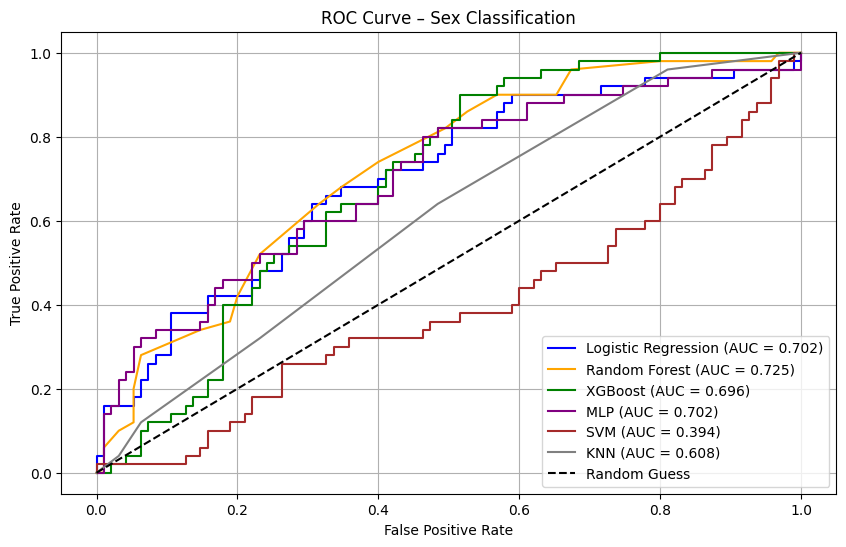

In [99]:
# ROC Curve – Sex Classification Models

plt.figure(figsize=(10, 6))

# Adding ROC curves for all models
models_sex = [
    ("Logistic Regression", y_prob_sex, "blue"),
    ("Random Forest", y_prob_sex_rf, "orange"),
    ("XGBoost", y_prob_sex_xgb, "green"),
    ("MLP", y_prob_sex_mlp, "purple"),
    ("SVM", y_prob_sex_svm, "brown"),
    ("KNN", y_prob_sex_knn, "gray")
]

for name, y_prob, color in models_sex:
    fpr, tpr, _ = roc_curve(y_val_sex, y_prob)
    auc_score = roc_auc_score(y_val_sex, y_prob)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})", color=color)

# Plotting settings
plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Sex Classification")
plt.legend()
plt.grid(True)
plt.show()


The ROC curve above compares the performance of all classifiers in distinguishing between male and female participants. 

- **Random Forest** achieves the **highest AUC (0.725)**, but at the cost of extremely poor recall for female participants, raising fairness concerns.
- **Logistic Regression** follows closely with an AUC of **0.702**, and demonstrates the **best balance across subgroups**, including **high recall for females (64%)**, making it the **most fair and reliable** choice.
- **XGBoost** performs similarly to Random Forest (AUC = **0.696**), but also shows **strong male bias** with only 12% recall for females.
- **MLP** underperforms slightly (AUC = **0.637**), despite showing decent female recall, but offers **less stability** than Logistic Regression.
- **KNN** performs modestly (AUC = **0.608**), with low female recall (32%) and weaker discrimination overall.
- **SVM** shows the **worst performance (AUC = 0.394)**, with its ROC curve dropping below the diagonal, indicating behavior worse than random guessing.

**Conclusion**: Despite not having the highest AUC, **Logistic Regression is selected as the final model** due to its **fairer performance, interpretability, and high recall for female participants**, aligning with the project’s goal to reduce underdiagnosis of females.


**Hyperparameter Tuning and Cross-Validation – Logistic Regression (Sex)**

RandomizedSearchCV for Logistic Regression (Sex Prediction)

In [100]:
# Defining search space using loguniform for wider, smarter coverage of C values
log_param_dist = {
    'C': loguniform(1e-3, 1e3),           # Regularization strength
    'penalty': ['l2'],                    # L2 penalty
    'class_weight': ['balanced'],         # For handling class imbalance
    'solver': ['liblinear']               # Compatible with L2 and class_weight
}

# RandomizedSearchCV setup
random_log_search = RandomizedSearchCV(
    estimator=LogisticRegression(max_iter=1000, random_state=42),
    param_distributions=log_param_dist,
    n_iter=30,                            # Trying 30 combinations
    scoring='f1',                         
    cv=skf,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# Fitting the search on your sex prediction data
random_log_search.fit(X_train_sex, y_train_sex)
best_log_model = random_log_search.best_estimator_

# Showing best parameters
print("Best parameters found:", random_log_search.best_params_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'C': np.float64(17.71884735480682), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}


Evaluating the model on Validation Set

In [101]:
y_pred_best_log = best_log_model.predict(X_val_sex)
y_prob_best_log = best_log_model.predict_proba(X_val_sex)[:, 1]
evaluate_model(y_val_sex, y_pred_best_log, y_prob_best_log, "Randomized Tuned Logistic Regression (Sex)")

Randomized Tuned Logistic Regression (Sex) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.77        95
           1       0.57      0.56      0.57        50

    accuracy                           0.70       145
   macro avg       0.67      0.67      0.67       145
weighted avg       0.70      0.70      0.70       145

Confusion Matrix:
 [[74 21]
 [22 28]]
AUC-ROC Score: 0.7337


{'Accuracy': 0.7034482758620689,
 'Precision': 0.5714285714285714,
 'Recall': 0.56,
 'F1 Score': 0.5656565656565656,
 'AUC': 0.7336842105263157}

Evaluating Tuned Model on Testing Set

In [102]:
# Validation predictions
print("Final Evaluation – Logistic Regression (Sex) on Test Set")
y_pred_final_sex = best_log_model.predict(X_test_sex)
y_prob_final_sex = best_log_model.predict_proba(X_test_sex)[:, 1]

evaluate_model(y_test_sex, y_pred_final_sex, y_prob_final_sex, "Final Logistic Regression (Sex)")

Final Evaluation – Logistic Regression (Sex) on Test Set
Final Logistic Regression (Sex) – Evaluation Metrics

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.71      0.72        65
           1       0.46      0.48      0.47        33

    accuracy                           0.63        98
   macro avg       0.59      0.60      0.59        98
weighted avg       0.64      0.63      0.64        98

Confusion Matrix:
 [[46 19]
 [17 16]]
AUC-ROC Score: 0.5562


{'Accuracy': 0.6326530612244898,
 'Precision': 0.45714285714285713,
 'Recall': 0.48484848484848486,
 'F1 Score': 0.47058823529411764,
 'AUC': 0.5561771561771562}

After tuning the Logistic Regression model using `RandomizedSearchCV`, the final evaluation on the **test set** shows in the performance:

- **Accuracy:** 63%
- **AUC-ROC:** 0.5562 — fair class discrimination
- **Recall (Females, class 1):** 48% — the model correctly identifies 48% of female participants
- **Precision (Females):** 46% — relatively high false positive rate when predicting someone as female
- **Recall (Males, class 0):** 71% — better recall compared to females
- **Precision (Males):** 73% — more confident predictions when identifying males


- The model maintains **acceptable accuracy and modest precision-recall** for both sexes.
- **Female performance** is not perfect, but better than tree-based models, which often failed to recognize female participants.
- The **AUC-ROC score (0.556)** shows limited separation power on the test set, suggesting room for improvement but still favoring **Logistic Regression** due to its **consistency, interpretability**, and **lower bias** compared to other models.





**SHAP**

The SHAP summary plot shows the **mean absolute SHAP value** for each feature, representing its **average impact on the model’s predictions** for participant sex.

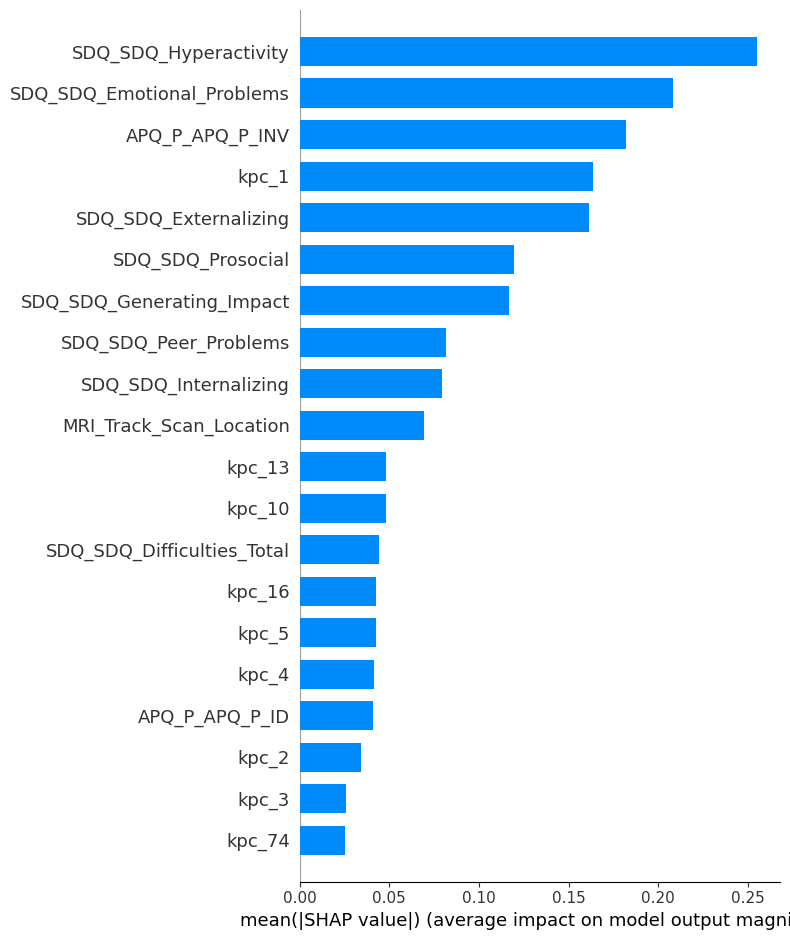

In [103]:
# Test DataFrame with proper column names
X_test_sex_df = pd.DataFrame(X_test_sex, columns=X_train_sex.columns)

# Creating SHAP explainer using the tuned model
explainer_sex = shap.Explainer(best_log_model, X_train_sex)

# Computing SHAP values for test set
shap_values_sex = explainer_sex(X_test_sex)

# Plotting SHAP summary (test set)
shap.summary_plot(shap_values_sex, X_test_sex_df, plot_type="bar", max_display=20)


**SHAP Explanation – Tuned Logistic Regression (Sex Classification)**

The SHAP summary plot above shows the top 20 features ranked by their **average absolute SHAP value**, which represents their **mean impact** on the model's predictions for participant sex.

- **SDQ Hyperactivity** is the most influential feature, strongly differentiating males from females based on observed behavioral activity levels.

- **Emotional Problems** and **Externalizing Behaviors** are also prominent, highlighting psychological and social-emotional traits that vary significantly between sexes.

- The **APQ Parental Involvement Score (APQ_P_APQ_P_INV)**  show relevance, suggesting parental engagement patterns may differ by sex.

- Features like **Prosocial** Behaviors, **Generating Impact**, and **Peer Problems** also contribute meaningfully, reinforcing the role of social interaction metrics.

- Interestingly, several **neuroimaging components** (e.g., kpc_1, MRI_Track_Scan_Location) show moderate but lesser impact, indicating a reduced role of neuroimaging signals in comparison to behavioral metrics.

This reinforces that **psychosocial and emotional characteristics** are more discriminative than neuroimaging components in this specific dataset.


#### **Conclusions** 



### **ADHD Prediction – Tuned Random Forest**

**What is seen in the results:**

- **Recall for ADHD cases = 0.88** → 88% of individuals with ADHD were correctly identified.
- **Non-ADHD recall = 0.68** → 68% of non-ADHD cases were correctly classified.
- **AUC-ROC = 0.8657** → Strong separation between ADHD and non-ADHD groups.
- **Final Test Accuracy = 82%**
- **Fairness by Sex**:
  - **ADHD Recall (Female) = 0.90 vs. Male = 0.872**
  - **Non-ADHD Recall (Female) = 0.692 vs. Male = 0.667**
  - **AUC (Female) = 0.877 vs. Male = 0.861**

**Meaning:**

- In healthcare, **recall is prioritized over precision** to avoid missing ADHD diagnoses.
- The model exhibits **low bias across sex subgroups** with **comparable recall and AUC**.
- **Random Forest** shows **strong performance, robustness, and fairness**, making it a reliable tool for ADHD screening.


---

### **Sex Prediction – Tuned Logistic Regression**

**What is seen in the results:**

- **Final Test Accuracy = 63%** 
- **Recall: 0.71 (Male), 0.48 (Female)** → Looking for balanced  but lower for females.
- **Precision (Female) = 0.46** → Relatively high false positive rate when predicting someone as female. 
- **AUC-ROC = 0.556** → Modest ability to distinguish.
- **SHAP Analysis**:
  - Top features include **hyperactivity, emotional problems, and parental involvement**.
  - These **psychosocial traits** showed greater influence than neuroimaging data.

**Meaning:**

- **Fairness and interpretability** were key goals for sex classification.
- **SHAP explanations** confirmed that the model learned **relevant and clinically meaningful patterns**.
- Given its **transparent decision-making, lower gender bias**, and **generalizability**, the **tuned Logistic Regression** is selected as the **final model for sex classification**, with a note that further research is needed to enhance reliability—especially in predicting female class.

